In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
%matplotlib inline

import sklearn
from sklearn.datasets import fetch_california_housing

plt.rcParams['font.size'] = 14

In [2]:
# Download data

tmp = sklearn.datasets.fetch_california_housing()

num_samples   = tmp['data'].shape[0]
feature_names = tmp['feature_names']
y = tmp['target']
X = tmp['data']

data = {}
for n, feature in enumerate(feature_names):
    data[feature] = tmp['data'][:,n]

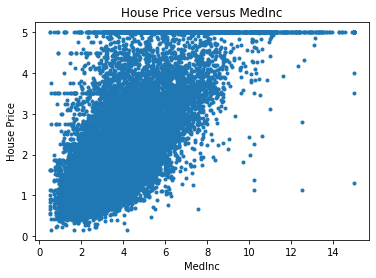

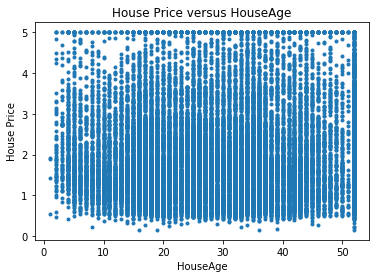

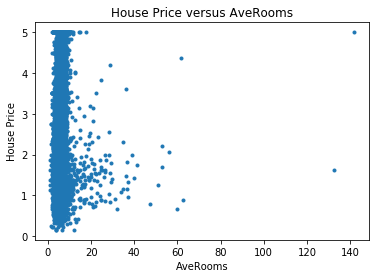

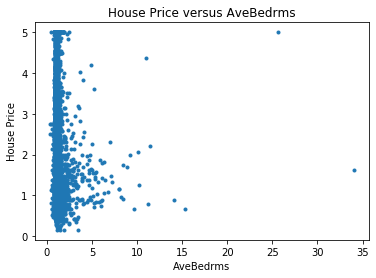

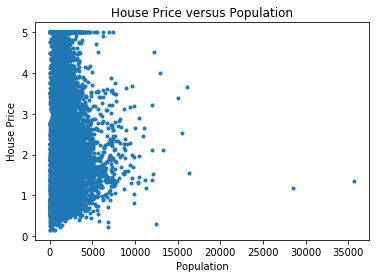

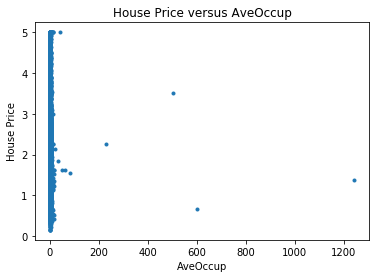

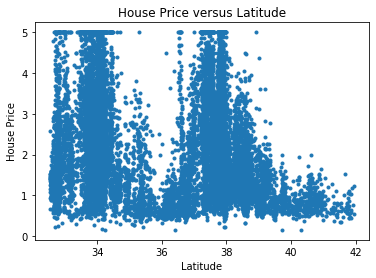

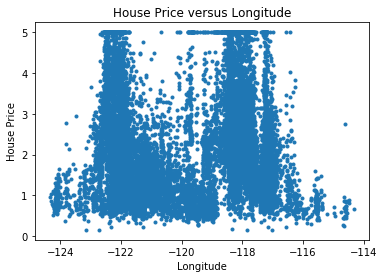

In [3]:
for k in data:
    x_plt = data[k]
    y_plt = y
    plt.plot(x_plt, y_plt,".")
    plt.title('House Price versus '+k)
    plt.xlabel(k)
    plt.ylabel('House Price')
    plt.show()

In [4]:
# Create stumps

# bin the data by proportion, 10% in each bin
bins = {}
bin_idx = (np.arange(0,1.1,0.1)*num_samples).astype(np.int16)
bin_idx[-1] = bin_idx[-1]-1
for feature in (feature_names):
    bins[feature] = np.sort(data[feature])[bin_idx]

# decision stumps as weak classifiers
# 0 if not in bin, 1 if in bin
stumps = {}
for feature in feature_names:
    stumps[feature] = np.zeros([num_samples,len(bins[feature])-1])
    for n in range(len(bins[feature])-1):
        stumps[feature][:,n] = data[feature]>bins[feature][n]

# stack the weak classifiers into a matrix
H = np.hstack([stumps[feature] for feature in feature_names])
H = np.hstack([np.ones([num_samples,1]),H])
# prepare the vector for storing weights
alphas = np.zeros(H.shape[1])

### AdaBoost

In [5]:
num_iterations = 30
MSE = np.zeros(num_iterations) # track mean square error

In [6]:
print(H.shape)

(20640, 81)


In [7]:
for iteration in range(num_iterations):
    f = np.dot(H, alphas)# the current f(x)
    r = y-f; MSE[iteration] = np.mean(r**2) # r = residual 
    idx = np.argmax(np.absolute(2*np.dot(H.T, r)/H.shape[0]))# optimal direction to move in
    alphas[idx] = alphas[idx] + np.dot(H[:,idx].T,r)/np.dot(H[:,idx].T,H[:,idx])# amount to move in optimal direction
print(MSE)

[5.6104832  1.3315503  1.10277822 0.95540752 0.898362   0.86125809
 0.74690513 0.72025217 0.70648854 0.68157957 0.67234355 0.65393067
 0.64461023 0.61988225 0.61281034 0.59516855 0.54493332 0.53715889
 0.53004768 0.52241438 0.51758036 0.51418661 0.5117528  0.50919409
 0.50734531 0.50447474 0.50154187 0.49851258 0.49661344 0.49531801]


### Plot Results

In [8]:
alphasf = {}
start = 1
for feature in feature_names:
    alphasf[feature] = alphas[start:(start+stumps[feature].shape[1])]
    start = start + stumps[feature].shape[1]
alphasf['mean'] = alphas[0]

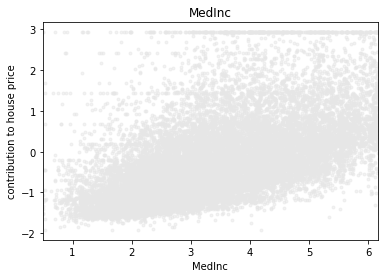

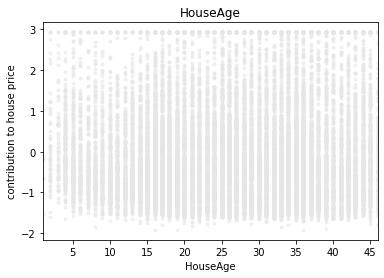

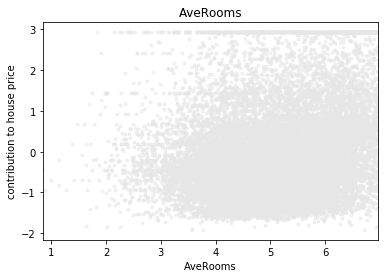

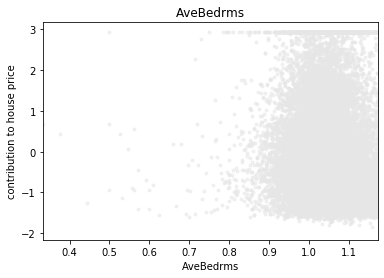

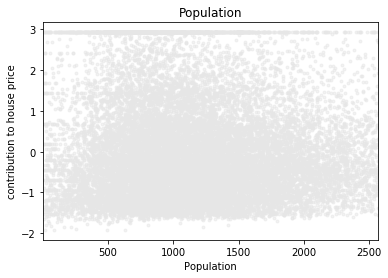

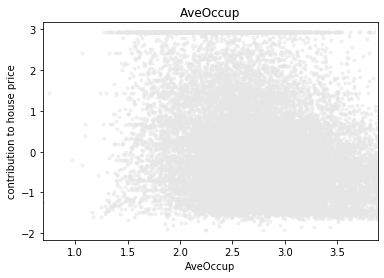

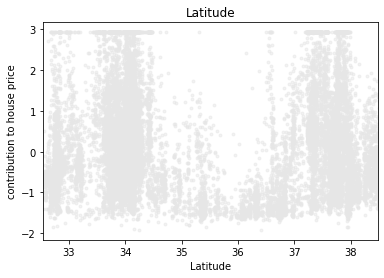

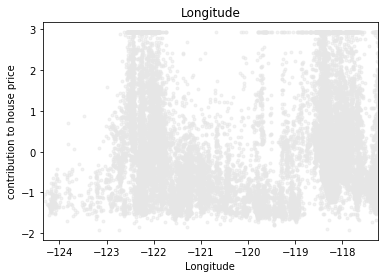

In [9]:
for feature in feature_names:
    plt.close("all")
    plt.plot(data[feature],y-np.mean(y),'.',alpha=0.5,color=[0.9,0.9,0.9])
    # plot stuff
    plt.title(feature)
    plt.xlim([bins[feature][0],bins[feature][-2]])
    plt.xlabel(feature)
    plt.ylabel('contribution to house price')
    plt.show()

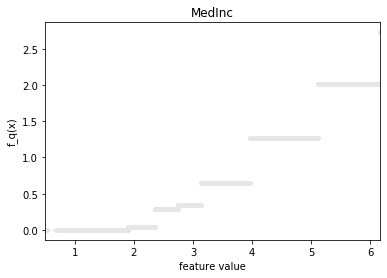

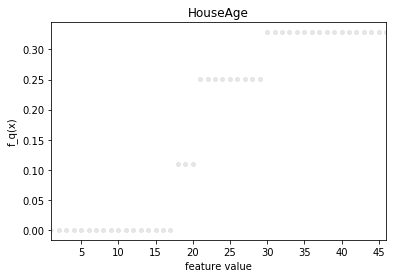

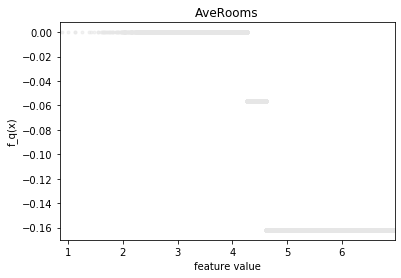

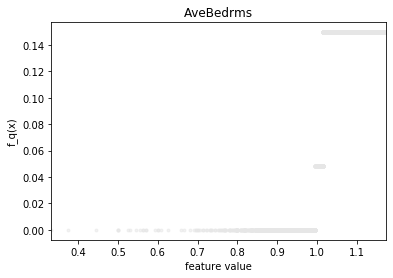

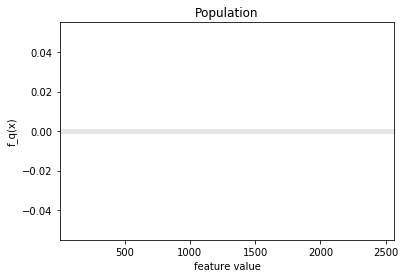

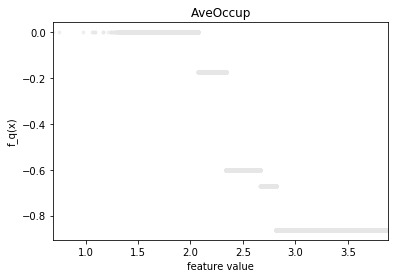

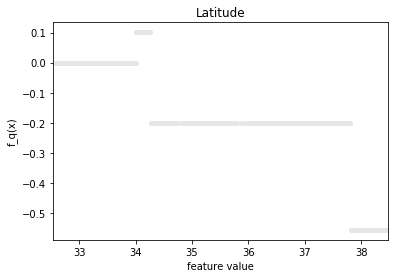

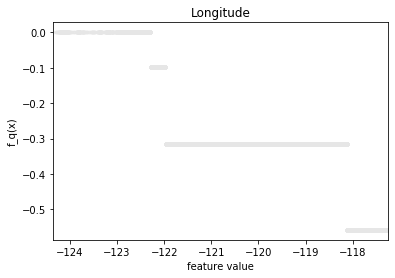

In [10]:
fqs = H*alphas
for i in range(len(feature_names)):
    feature = feature_names[i]
    fq = np.sum(fqs[:,i*10+1:i*10+11], axis = 1)
    fv = data[feature]
    plt.close("all")
    plt.plot(fv, fq, '.',alpha=0.5,color=[0.9,0.9,0.9])
    plt.title(feature)
    plt.xlim([bins[feature][0],bins[feature][-2]])
    plt.xlabel("feature value")
    plt.ylabel("f_q(x)")
    plt.show()

### Variable Importance

In [11]:
np.random.seed(1)
f = np.dot(H, alphas)
r = y-f; mse = np.mean(r**2)
for i in range(len(feature_names)):
    feature = feature_names[i]
    f_rd = np.random.permutation(data[feature])
    H_new = np.copy(H)
    stump = np.zeros([num_samples,len(bins[feature])-1])
    for n in range(len(bins[feature])-1):
        stump[:,n] = f_rd>bins[feature][n] 
    H_new[:, i*10+1: i*10+11] = stump
    f_new = np.dot(H_new, alphas)
    r = y-f_new; mse_new = np.mean(r**2)
    print(feature, mse_new-mse)

MedInc 1.4331128672150466
HouseAge 0.03866319569416726
AveRooms 0.016203052691988018
AveBedrms 0.010925414968096792
Population 0.0
AveOccup 0.18826518644584106
Latitude 0.12571188168943298
Longitude 0.08159588528608269


### Boosted Decision Trees

In [12]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import plot_partial_dependence

In [13]:
clf = GradientBoostingRegressor(loss="ls")
clf.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

/anaconda2/envs/mlhw/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function plot_partial_dependence is deprecated; The function ensemble.plot_partial_dependence has been deprecated in favour of sklearn.inspection.plot_partial_dependence in  0.21 and will be removed in 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda2/envs/mlhw/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function partial_dependence is deprecated; The function ensemble.partial_dependence has been deprecated in favour of inspection.partial_dependence in 0.21 and will be removed in 0.23.
  warnings.warn(msg, category=DeprecationWarning)
/anaconda2/envs/mlhw/lib/python3.7/site-packages/sklearn/utils/deprecation.py:85: DeprecationWarning: Function partial_dependence is deprecated; The function ensemble.partial_dependence has been deprecated in favour of inspection.partial_dependence in 0.21 and will be removed in 0.23.
  warnings.warn(ms

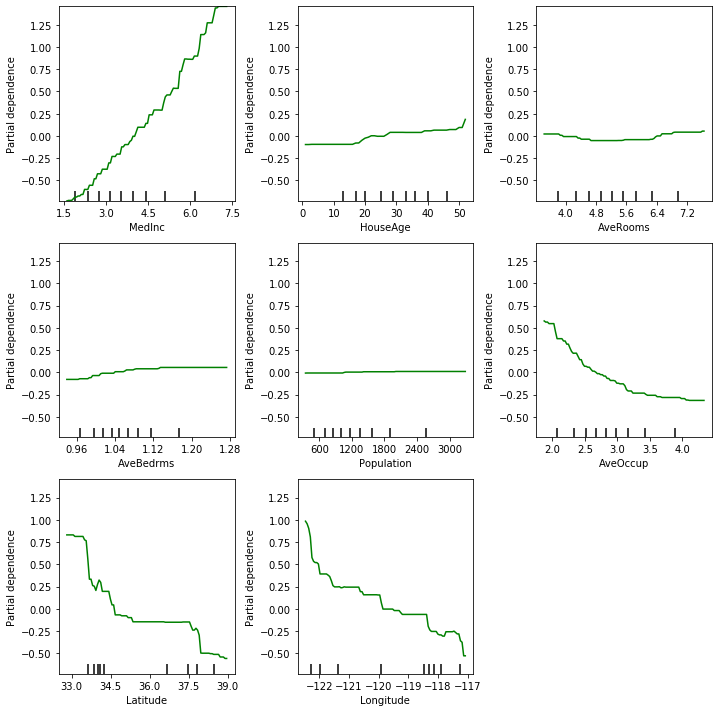

In [14]:
plt.close("all")
plt.figure(figsize=[10,10])
ax = plt.gca()
plot_partial_dependence(clf, X, feature_names, feature_names, n_cols=3, ax=ax) 
plt.tight_layout()
plt.show()

### Linear Regression

In [15]:
from sklearn.linear_model import LinearRegression

In [16]:
clf2 = LinearRegression()
clf2.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Comparison in MSE

In [17]:
np.mean((y-clf2.predict(X))**2)

0.5243209861846071

In [18]:
np.mean((y-clf.predict(X))**2)

0.26188431965892933